Let's consider a simple instance, Burgers Equation:

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}=\nu\frac{\partial^2u}{\partial x^2}$$

$$x\in[-1,1],\quad t\in[0,1]$$

with the Dirichlet boundary conditions and initial conditions

$$u(-1,t)=u(1,t)=0,\quad u(x,0)=-\sin(\pi x).$$

Step 1: Setup

In [1]:
import sys
sys.path.append('H:/毕业论文/pykan')
# from efficient_kan import KAN, KANLinear
# import deepxde as dde
import torch
import torch.nn as nn
from torch import autograd
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
from kan import KAN, LBFGS
# from kan import LBFGS
import numpy as np
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)

def batch_hessian(func, x):
    jacobian = batch_jacobian(func, x, create_graph=True)
    hessians = []
    for i in range(jacobian.size(1)):
        grad = autograd.grad(jacobian[:, i].sum(), x, create_graph=True, retain_graph=True)[0]
        hessians.append(grad.unsqueeze(1))
    return torch.cat(hessians, dim=1)

Using device: cuda:0


Step 2:

In this Part, according to the problem, we need to construct the specific PDE.

In [2]:
#geom 物理区域
geom = [-1.0,1.0]
num_points_x = 150  #网格的大小

#时间区域  For time-independent PDE, we don't need this.
TimeDomain = [0,1.0]
num_points_t = 100

# geomtime = dde.geometry.GeometryXTime(dde.geometry.Interval(geom[0],geom[1]),dde.geometry.TimeDomain(TimeDomain[0],TimeDomain[1]))

#网格化
x = torch.linspace(geom[0], geom[1], 
                   steps=num_points_x, device=device,
                   requires_grad=False)

t = torch.linspace(TimeDomain[0],TimeDomain[1],
                   steps=num_points_t, device=device,
                   requires_grad=False)

X,T = torch.meshgrid(x, t, indexing='ij')
coordinates = torch.stack([X.flatten(), T.flatten()], dim = 1).to(device)
print(coordinates.shape)
coordinates.requires_grad = True  # Ensure coordinates require grad 确保coordinates需要梯度
##
##这一步的目的是生成一个二维网格，将空间和时间域内的离散点组合成所有可能的坐标对，
##从而用于进一步的计算或模型训练。这种方法常用于物理学、工程学和机器学习中的数值模拟和求解偏微分方程（PDEs）

torch.Size([15000, 2])


Step 3: KAN

In [3]:
#注意到我们其实需要的是一个 两个输入x和t 一个输出真解u 的KAN神经网络
layer = [2] + [2]*2 + [1]   #[input] + [nn]*hiden + [output] 

#oringinal KAN
model = KAN(width=layer, grid=3, k=3, grid_eps=1,
            noise_scale_base=0.25,device = device)

#efficient - KAN
# model = KAN(layer,grid_size=3,spline_order=3,scale_noise=0.1,grid_eps=1.0,base_activation=nn.Identity).to(device)

由于边界条件：

$$u(-1,t)=u(1,t)=0,~~~~~ \mathrm{MSE_{BC}}(u_{pred},0)$$

由于初始条件：

$$\quad u(x,0)=-\sin(\pi x), ~~~~~\mathrm{MSE_{IC}}(u_{pred}, -\sin(\pi x))$$



In [4]:
def pde(coords):
    #前置定义过程
    coords = coords.clone().detach().requires_grad_(True)  # Ensure coords require grad
    grads = batch_jacobian(model , coords, create_graph= True)  #计算Jacobian矩阵 batch_jacobian(fun, variable, creat_graph = True)
    hessians = batch_hessian(model, coords)

    #PDE的定义过程： 
    u = model(coords)  #predicted solution
    
    #coords[X,T]  [:, :, :]  前两个指的的真解u 后一个指的是对应的x和t x：0  t：1
    u_t = grads[:,0,1]  #d_u/dt
    print("u_t: ",u_t,u_t.shape)
    u_x = grads[:,0,0]  #d_u/dx
    print("u_x: ",u_x,u_x.shape)
    u_xx = hessians[:,0, 0]  #d^2_u/dx^2

    #residuals of PDE：PDE的残差
    equation = u_t + u * u_x - 0.01 / np.pi * u_xx
    pde_loss = torch.mean(equation ** 2)

    # bc_loss = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
    # ic_loss = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)

    # BC and IC: 找到位于边界和初始上的点
    BC_mask = (coords[:, 0] == geom[0]) | (coords[:, 0] == geom[1])
    IC_mask = (coords[:, 1] == TimeDomain[0])
    
    BC_points = coords[BC_mask][:,0].unsqueeze(1)
    IC_points = coords[IC_mask][:,0].unsqueeze(1)

    # print("IC_X:",IC_points,IC_points.shape)

    # print("BC_POINT",coords[BC_mask],coords[BC_mask].shape)
    # print("IC_POINT",coords[IC_mask],coords[IC_mask].shape)

    ##BC:边界条件
    model_bc = model(coords[BC_mask])  #coords[BC_mask][X:T] X:-1.0 and 1.0  T:uniform[0,1]  [200 x 2]
    bc_loss = torch.mean(model_bc**2)

    ##IC:初始条件
    model_ic = model(coords[IC_mask])  #coords[IC_mask][X:T] X:uniform[-,1]  T:0  [200 x 2]
    true_ic = -torch.sin(np.pi * IC_points)
    ic_loss = torch.mean((model_ic - true_ic)**2)  #Only ic need a minus-form
    #print("BC:", bc_loss)
    #print("IC:", ic_loss)
    #print("PDE:", pde_loss)
    total_loss = pde_loss + ic_loss + bc_loss
    
    return total_loss

Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]

u_t:  tensor([0.1260, 0.1280, 0.1300,  ..., 0.2170, 0.2193, 0.2217], device='cuda:0',
       grad_fn=<SelectBackward0>) torch.Size([15000])
u_x:  tensor([-0.0127, -0.0127, -0.0127,  ..., -0.2165, -0.2180, -0.2194],
       device='cuda:0', grad_fn=<SelectBackward0>) torch.Size([15000])
u_t:  tensor([0.1209, 0.1228, 0.1246,  ..., 0.2047, 0.2069, 0.2091], device='cuda:0',
       grad_fn=<SelectBackward0>) torch.Size([15000])
u_x:  tensor([-0.0123, -0.0123, -0.0123,  ..., -0.2083, -0.2096, -0.2110],
       device='cuda:0', grad_fn=<SelectBackward0>) torch.Size([15000])
u_t:  tensor([0.0992, 0.1004, 0.1016,  ..., 0.1573, 0.1592, 0.1611], device='cuda:0',
       grad_fn=<SelectBackward0>) torch.Size([15000])
u_x:  tensor([-0.0108, -0.0108, -0.0108,  ..., -0.1758, -0.1767, -0.1777],
       device='cuda:0', grad_fn=<SelectBackward0>) torch.Size([15000])
u_t:  tensor([0.0963, 0.0974, 0.0985,  ..., 0.1513, 0.1531, 0.1550], device='cuda:0',
       grad_fn=<SelectBackward0>) torch.Size([15000])
u_

Step: 0 | Loss: 0.219: 100%|██████████| 1/1 [00:05<00:00,  5.57s/it]

u_t:  tensor([-0.3272, -0.3283, -0.3292,  ...,  0.1029,  0.1075,  0.1122],
       device='cuda:0', grad_fn=<SelectBackward0>) torch.Size([15000])
u_x:  tensor([0.5633, 0.5627, 0.5620,  ..., 0.3159, 0.3136, 0.3113], device='cuda:0',
       grad_fn=<SelectBackward0>) torch.Size([15000])
[0.2186005413532257]


Text(0.5, 1.0, 'Loss of KAN')

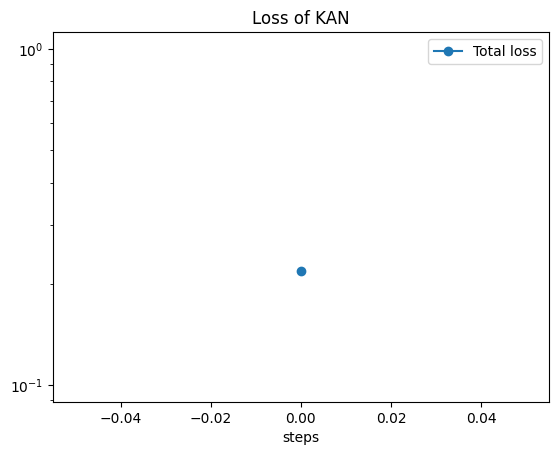

In [5]:
Loss = []
l2_losses = []
writer = SummaryWriter()

def train():
    optimizer = LBFGS(model.parameters(), lr=1e-1,
                      history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    # optimizer = optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False)
    
    steps = 1 # 20 steps are enough
    pbar = tqdm(range(steps), desc='Training Progress')

    for step in pbar:
        def closure():
            optimizer.zero_grad()
            loss = pde(coordinates)
            loss.backward()
            return loss

        optimizer.step(closure)
        if step % 2 == 0:
            current_loss = closure().item()
            pbar.set_description("Step: %d | Loss: %.3f" %
                                 (step, current_loss))
            writer.add_scalar('Loss/train', current_loss, step)
        Loss.append(closure().item())
        # l2_losses.append(l2.detach().numpy())
        # print("Current Loss: ",Loss[step])

train()
writer.close()
print(Loss)
plt.plot(Loss, marker='o')
plt.plot(l2_losses, marker='o')
plt.yscale('log')
plt.xlabel('steps')
plt.legend(['Total loss'])
plt.title('Loss of KAN') 

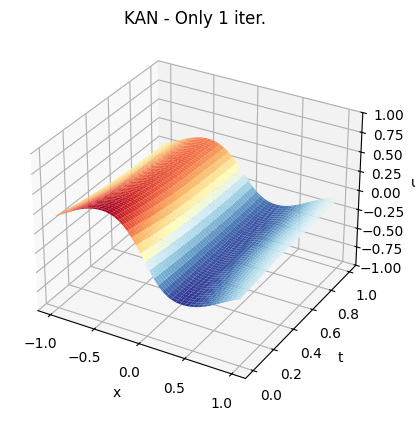

In [6]:
#画图
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
import matplotlib.pyplot as plt

t = np.linspace(0,1,100)
x = np.linspace(-1,1,256)
ms_x, ms_t = np.meshgrid(x, t)
x = np.ravel(ms_x).reshape(-1, 1)
t = np.ravel(ms_t).reshape(-1, 1)
pt_x = torch.from_numpy(x).float().requires_grad_(True).to(device)
pt_t = torch.from_numpy(t).float().requires_grad_(True).to(device)
pt_u0 = model(torch.cat([pt_x,pt_t],1))
u = pt_u0.data.cpu().numpy()

pt_u0=u.reshape(100,256)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_zlim([-1, 1])
ax.plot_surface(ms_x, ms_t, pt_u0, cmap=cm.RdYlBu_r, edgecolor='blue', linewidth=0.0003, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.title('KAN - Only 1 iter.') 
plt.savefig('KAN.png')
plt.show(fig)

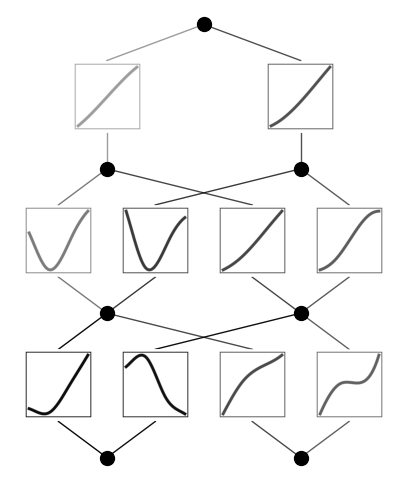

In [7]:
model.plot(beta=10)